# Classical Learning

<div style="background-color: #f8d7da; border-left: 6px solid #ccc; margin: 20px; padding: 15px;">
    <strong>💡 Hugh Cartwright:</strong> The tools of science are changing; artificial intelligence has spread to the laboratory.
</div>

<iframe class="speakerdeck-iframe" frameborder="0" src="https://speakerdeck.com/player/b098c15f50ce4a468a1c5eecd6de0f96" title="Machine Learning for Materials (Lecture 5)" allowfullscreen="true" style="border: 0px; background-clip: padding-box; background-color: rgba(0, 0, 0, 0.1); margin: 0px; padding: 0px; border-radius: 6px; box-shadow: rgba(0, 0, 0, 0.2) 0px 5px 40px; width: 100%; height: auto; aspect-ratio: 560 / 420;" data-ratio="1.3333333333333333"></iframe>

[Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-lecture5-classical)

## 🎲 Metal or insulator?

In life, some decisions are difficult to make. We hope that our experience informs a choice that is better than a random guess. The same is true for machine learning models.

There are many situations where we want to classify materials according to their properties. One fundamental characteristic is whether a material is a metal or insulator. For this exercise, we can refer to these as class `0` and class `1` materials, respectively. 

From our general knowledge, Cu should be `0` and MgO should be `1`, but what about Tl<sub>2</sub>O<sub>3</sub> or Ni<sub>2</sub>Zn<sub>4</sub>?

### Theoretical background

Metals are characterised by their free electrons that facilitate the flow of electric current. This arises from a partially filled conduction band, allowing electrons to move easily when subjected to an electric field.

Insulators are characterised by an occupied valence band and empty conduction band, impeding the flow of current. The absence of charge carriers hinders electrical conductivity, making them effective insulators of electricity. Understanding these fundamental differences is crucial for designing and optimising electronic devices.

In this practical, we can use the electronic band gap of a material as a simple descriptor of whether it is a metal (E<sub>g</sub> = 0) or an insulator (E<sub>g</sub> > 0).

$$
E_g = E^{conduction-band}_{minimum} - E^{valence-band}_{maximum}
$$

This classification is coarse as we are ignoring the intermediate regime of semiconductors and more exotic behaviour such as superconductivity.

![image](../images/5_bands.png)

## $k$-means clustering

Let's start by generating synthetic data for materials along with their class labels. To make the analysis faster and more illustrative, we can perform dimensionality reduction from a 10D to 2D feature space, and then cluster the data using $k$-means.

In [19]:
# # Installation of libraries
# !pip install elementembeddings --quiet
# !pip install matminer --quiet

In [20]:
# Import of modules
import numpy as np  # Numerical operations
import pandas as pd  # DataFrames
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Visualisation
from sklearn.decomposition import PCA  # Principal component analysis (PCA)
from sklearn.cluster import KMeans # k-means clustering
from sklearn.metrics import accuracy_score, confusion_matrix  # Model evaluation
from sklearn.tree import DecisionTreeClassifier  # Decision tree classifier

<details>
<summary>Colab error solution</summary>
If running the import module cell fails with an "AttributeError", click `Runtime` -> `Restart Session` and then simply rerun the cell.
</details>

### Uncorrelated data

Pay attention to each step in the process:

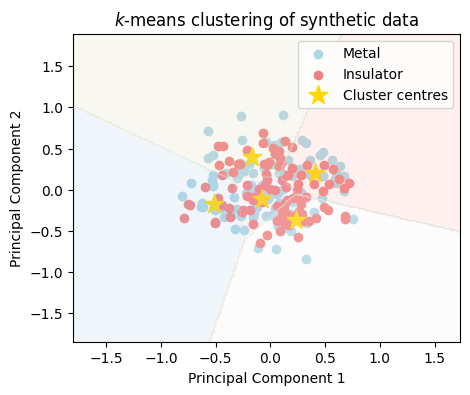

In [21]:
# Step 0: Set the number of clusters
n_clusters = 5

# Step 1: Generating synthetic (random) data
np.random.seed(42)
num_materials = 200
num_features = 10
data = np.random.rand(num_materials, num_features)
labels = np.random.randint(0, 2, num_materials)

# Step 2: Reduce dimensions to 2 using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Step 3: Cluster the data using k-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(reduced_data)

# Step 4: Create a plot to visualise the clusters and known labels
plt.figure(figsize=(5, 4))

# Plot the materials labeled as metal (label=1)
plt.scatter(reduced_data[labels == 1, 0], reduced_data[labels == 1, 1], c='lightblue', label='Metal')
# Plot the materials labeled as insulator (label=0)
plt.scatter(reduced_data[labels == 0, 0], reduced_data[labels == 0, 1], c='lightcoral', label='Insulator')
# Plot the cluster centres as stars
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='gold', s=200, label='Cluster centres', marker='*')

# Draw cluster boundaries
h = 0.02  # step size for the meshgrid
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='Pastel1')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('$k$-means clustering of synthetic data')
plt.legend()
plt.show()

<details>
<summary> Code hint </summary>
The algorithm fails for 0 clusters. 
Increase the value of `n_clusters` and look at the behaviour.
</details>

The cluster centres are shown by yellow stars. The model doesn't perform well, as we just generated this "materials data" from random numbers. There are no correlations for the algorithms to exploit. Nonetheless, this type of "failed experiment" is common in real research.

Since we know the labels, we can quantify how bad the model using the classification accuracy. Is it better than flipping a coin? 

In [22]:
# Step 5: Quantify classification accuracy
accuracy = accuracy_score(labels, predicted_labels)
conf_matrix = confusion_matrix(labels, predicted_labels)

print("Accuracy:", accuracy)
print("\nConfusion matrix:")
print(conf_matrix)

Accuracy: 0.165

Confusion matrix:
[[15 11 20 22 27]
 [23 18 26 22 16]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


## Decision tree classifier

Let's see if we can do better using a dedicated classifier. We will now train a decision tree to tackle the same problem and visualise the decision boundary.

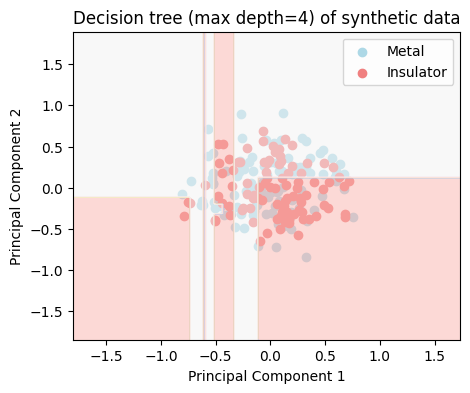

In [23]:
# Step 0: Set the depth of the decision tree
max_tree_depth = 4

# Step 1: Train a decision tree classifier
def train_decision_tree(depth, reduced_data, labels):
    tree_classifier = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_classifier.fit(reduced_data, labels)
    return tree_classifier

tree_classifier = train_decision_tree(max_tree_depth, reduced_data, labels)
predicted_labels = tree_classifier.predict(reduced_data)

# Step 2: Create a plot to visualise the decision boundary of the decision tree
plt.figure(figsize=(5, 4))

# Plot the materials labeled as metal (label=1)
plt.scatter(reduced_data[labels == 1, 0], reduced_data[labels == 1, 1], c='lightblue', label='Metal')
# Plot the materials labeled as insulator (label=0)
plt.scatter(reduced_data[labels == 0, 0], reduced_data[labels == 0, 1], c='lightcoral', label='Insulator')
# Plot the decision boundary of the decision tree classifier
h = 0.02  # step size for the meshgrid
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = tree_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.5, cmap='Pastel1')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Decision tree (max depth={max_tree_depth}) of synthetic data')
plt.legend()

plt.show()

<details>
<summary> Code hint </summary>
With no nodes, you have made an indecisive tree 🥁.
    
Increase the value of `max_tree_depth` and look at the behaviour.
</details>

There should be more structure in the decision boundary due to the more complex model, especially as you increase the tree depth.

$k$-means clustering provides a simple way to group materials based on similarity, yielding a clear linear decision boundary. On the other hand, the decision tree classifier does better in handling non-linear separations. It constructs a boundary based on different feature thresholds, enabling it to capture fine-grained patterns. As always in ML, there is a balance of trade-offs between simplicity and accuracy.

Is the decision tree more accurate? Let's see.

In [24]:
# Step 3: Quantify classification accuracy
accuracy = accuracy_score(labels, predicted_labels)
conf_matrix = confusion_matrix(labels, predicted_labels)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.66

Confusion Matrix:
[[64 31]
 [37 68]]


If you choose a large value for the tree depth, the decision tree will approach a perfect accuracy of 1.0. It does this by memorising (overfitting) the training data but is unlikely to generalise well to new (unseen) data, i.e. overfitting. In contrast, the accuracy of $k$-means clustering is lower because it is an unsupervised algorithm designed for clustering, not classification. Its performance depends on the data structure and the presence of distinct clusters in that feature space.

### Correlated data

Let's try again, but this time we will (manually) add some correlations into the dataset.

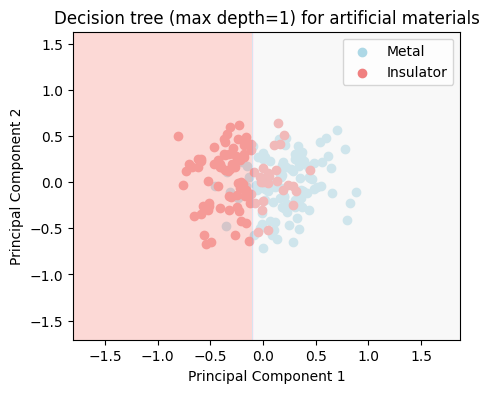

Accuracy: 0.83

Confusion Matrix:
[[70 25]
 [ 9 96]]


In [25]:
# Modify dataset with correlation
correlation_strength = 0.233
for i in range(num_features):
    # For some features, add a linear correlation with the labels
    if i % 2 == 0:  # Correlate every other feature
        data[:, i] = correlation_strength * labels + (1 - correlation_strength) * np.random.rand(num_materials)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Step 0: Set the depth of the decision tree
max_tree_depth = 1

# Step 1: Train a decision tree classifier
def train_decision_tree(depth, reduced_data, labels):
    tree_classifier = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_classifier.fit(reduced_data, labels)
    return tree_classifier

tree_classifier = train_decision_tree(max_tree_depth, reduced_data, labels)
predicted_labels = tree_classifier.predict(reduced_data)

# Step 2: Create a plot to visualise the decision boundary of the decision tree
plt.figure(figsize=(5, 4))

# Plot the materials labeled as metal (label=1)
plt.scatter(reduced_data[labels == 1, 0], reduced_data[labels == 1, 1], c='lightblue', label='Metal')
# Plot the materials labeled as insulator (label=0)
plt.scatter(reduced_data[labels == 0, 0], reduced_data[labels == 0, 1], c='lightcoral', label='Insulator')
# Plot the decision boundary of the decision tree classifier
h = 0.02  # step size for the meshgrid
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = tree_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.5, cmap='Pastel1')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Decision tree (max depth={max_tree_depth}) for artificial materials')
plt.legend()

plt.show()

# Step 3: Quantify classification accuracy
accuracy = accuracy_score(labels, predicted_labels)
conf_matrix = confusion_matrix(labels, predicted_labels)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)

Now even a very simple tree can effectively draw a decision boundary. Machine learning models take advantage of such correlations in high dimensional feature spaces. You can modify the correlation strength on line 2 to see the effect.

## Real materials

We can save time again by making use of a pre-built dataset. We will return to [matminer](https://hackingmaterials.lbl.gov/matminer), which we used before, and load `matbench_expt_is_metal`.

### Load dataset

In [26]:
import matminer
from matminer.datasets.dataset_retrieval import load_dataset

# Use matminer to download the dataset
df = load_dataset('matbench_expt_is_metal')
print(f'The full dataset contains {df.shape[0]} entries. \n')

# Display the first 10 entries
df.head(10)

The full dataset contains 4921 entries. 



,composition,is_metal
0,Ag(AuS)2,True
1,Ag(W3Br7)2,True
2,Ag0.5Ge1Pb1.75S4,False
3,Ag0.5Ge1Pb1.75Se4,False
4,Ag2BBr,True
5,Ag2BiO3,True
6,Ag2GeS3,False
7,Ag2GeSe3,False
8,Ag2GeTe3,False
9,Ag2HgI4,False


<details>
<summary> Code hint </summary>
To load a different dataset, you simply change the name in 'load_dataset()'.
</details>

### Materials featurisation

Revisiting concepts from earlier Notebooks, featurising the chemical compositions is necessary to create a useful set of input vectors. This allows the presence (or absence) of an element (or element combinations) to act as a feature that the classifier takes account for.

We will use [ElementEmbeddings](https://wmd-group.github.io/ElementEmbeddings) to featurise the `composition` column. The importance of the pooling method can be tested by generating two sets of features. In the first, the mean of the atomic vectors is used, while in the second, a max pooling method takes the maximum value of each component across all the atomic vectors in the composition.

In [27]:
# Featurise all chemical compositions
from elementembeddings.composition import composition_featuriser

# Compute element embeddings using mean and max pooling
mean_df = composition_featuriser(df["composition"], embedding="magpie", stats=["mean"])
max_df = composition_featuriser(df["composition"], embedding="magpie", stats=["maxpool"])

# Convert "is_metal" column to integer labels (0, 1)
df['is_metal'] = df['is_metal'].astype(int)
mean_df['is_metal'] = df['is_metal']
max_df['is_metal'] = df['is_metal']

# Define feature matrices and target variable
cols_to_drop = ['is_metal', 'formula']

X_mean = mean_df.drop(columns=cols_to_drop, errors='ignore').values
X_max = max_df.drop(columns=cols_to_drop, errors='ignore').values
y = df['is_metal'].values  # Target variable

# Preview first two rows 
print("Mean pooling features (first two rows, first 4 columns):")
print(mean_df.iloc[:2, :4])  
print("\nMax pooling features (first two rows, first 4 columns):")
print(max_df.iloc[:2, :4]) 

Featurising compositions...


100%|██████████| 4921/4921 [00:06<00:00, 767.59it/s]


Computing feature vectors...


100%|██████████| 4921/4921 [00:00<00:00, 293492.73it/s]


Featurising compositions...


100%|██████████| 4921/4921 [00:05<00:00, 863.53it/s]


Computing feature vectors...


100%|██████████| 4921/4921 [00:00<00:00, 186864.97it/s]

Mean pooling features (first two rows, first 4 columns):
      formula  mean_Number  mean_MendeleevNumber  mean_AtomicWeight
0    Ag(AuS)2    47.400000                  74.6         113.186268
1  Ag(W3Br7)2    46.714286                  81.0         110.931629

Max pooling features (first two rows, first 4 columns):
      formula  maxpool_Number  maxpool_MendeleevNumber  maxpool_AtomicWeight
0    Ag(AuS)2            79.0                     88.0            196.966569
1  Ag(W3Br7)2            74.0                     95.0            183.840000


In the output, you can see two numerical representations of the chemical compositions using different feature extraction techniques. Now let's see how they cluster.

### $k$-means clustering 

#### Mean pool

Accuracy: 0.70


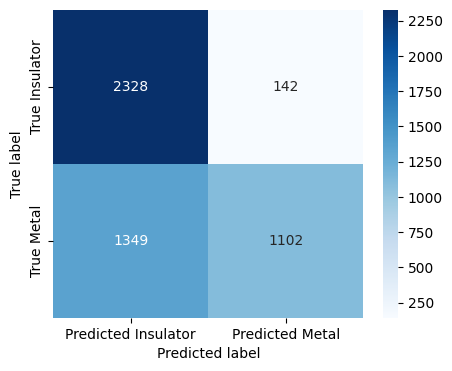

In [28]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
predicted_labels = kmeans.fit_predict(X_mean)

# Adjust k-means output to match true labels
if accuracy_score(y, predicted_labels) < 0.5:
    predicted_labels = 1 - predicted_labels

# Assess performance
accuracy = accuracy_score(y, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

conf_matrix = confusion_matrix(y, predicted_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Predicted Insulator', 'Predicted Metal'], 
            yticklabels=['True Insulator', 'True Metal'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Max pool

Accuracy: 0.61


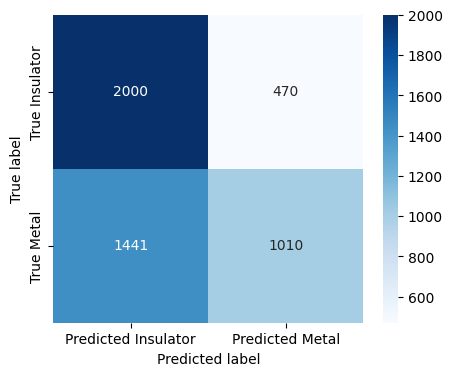

In [29]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
predicted_labels = kmeans.fit_predict(X_max)

# Adjust k-means output to match true labels
if accuracy_score(y, predicted_labels) < 0.5:
    predicted_labels = 1 - predicted_labels

# Assess performance
accuracy = accuracy_score(y, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

conf_matrix = confusion_matrix(y, predicted_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Predicted Insulator', 'Predicted Metal'], 
            yticklabels=['True Insulator', 'True Metal'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

The difference in accuracy between the two methods for this simple example highlights the importance of choosing an appropriate pooling strategy when featurising materials data. In this case, mean pooling provides a more balanced representation, which better distinguishes between metals and insulators.

## 🚨 Exercise 5

<div style="background-color: #dceefb; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>💡 Coding exercises:</strong> The exercises are designed to apply what you have learned with room for creativity. It is fine to discuss solutions with your classmates, but the actual code should not be directly copied.
</div>

### Your details

In [30]:
import numpy as np

# Insert your values
Name = "Ayham Al-Saffar" # Replace with your name
CID = 2137313 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

This is the work of Ayham Al-Saffar [CID: 2137313]


### Problem

The choice of featurisation method can significantly impact the performance of machine learning models, particularly in decision trees, which rely on the features to make accurate splits. 

Tasks will be given in class focusing on comparing the impact of different featurisation methods on classification performance.

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [40]:
tree_model = DecisionTreeClassifier()
mean_pooling_scores = cross_val_score(tree_model, X_mean, y, cv=5, scoring='f1')
max_pooling_scores = cross_val_score(tree_model, X_max, y, cv=5, scoring='f1')
print("Tree Model Results:")
print(f"cross validated average mean pooling f1 score = {np.mean(mean_pooling_scores):.3f}")
print(f"cross validated average max pooling f1 score = {np.mean(max_pooling_scores):.3f}")

Tree Model Results:
cross validated average mean pooling f1 score = 0.822
cross validated average max pooling f1 score = 0.762


In [41]:
cluster_model = KMeans(n_clusters=2, random_state=42)
mean_pooling_scores = cross_val_score(cluster_model, X_mean, y, cv=5, scoring='f1')
max_pooling_scores = cross_val_score(cluster_model, X_max, y, cv=5, scoring='f1')
print("Cluster Model Results")
print(f"cross validated average mean pooling f1 score = {np.mean(mean_pooling_scores):.3f}")
print(f"cross validated average max pooling f1 score = {np.mean(max_pooling_scores):.3f}")

Cluster Model Results
cross validated average mean pooling f1 score = 0.589
cross validated average max pooling f1 score = 0.390


Tree model consistently outperforms clustering model perhaps due to its added complexity and predictive power.

In both cases, using mean pooling gives a higher classification score, inferring that taking the average of each atom's properties in a compound is the best representation of the information for modelling. This also highlights how important feature engineering is.

<details>
<summary> Task hint </summary>
For task 4, you can featurise a new composition using a command such as `new_material = composition_featuriser(["AlGaN2"], embedding="atomic", stats=["sum"])`
</details>

<div style="background-color: #d4edda; border-left: 6px solid #ccc; margin: 20px; padding: 15px; border-radius: 5px;">
    <strong>📓 Submission:</strong> When your notebook is complete in Google Colab, go to <em>File > Download</em> and choose <code>.ipynb</code>. The completed file should be uploaded to Blackboard under assignments for MATE70026.
</div>

## 🌊 Dive deeper

* _Level 1:_ Tackle Chapter 6 on Linear Two-Class Classification in [Machine Learning Refined](https://github.com/jermwatt/machine_learning_refined#what-is-new-in-the-second-edition).

* _Level 2:_ Play [metal detection](http://palestrina.northwestern.edu/metal-detection/). Note, the website can be a little temperamental. 

* _Level 3:_ Dig deeper into the options for definitions decision trees and ensemble models in [scikit-learn](https://scikit-learn.org/stable/modules/tree.html).